In [2]:
from keras.models import load_model

Using TensorFlow backend.


In [3]:
import os
folder_name = "models"
def load_model_helper(name):
    files = os.listdir(folder_name)
    for f in files:
        if name in f:
            return load_model("{}/{}".format(folder_name,f))

In [33]:
coin_name = '0x'
model = load_model_helper("{}_".format(coin_name))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, None, 100)         40800     
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params: 121,301
Trainable params: 121,301
Non-trainable params: 0
_________________________________________________________________


In [34]:
from coinmarketcap_draw import coinmarketcap_data

In [35]:
data = coinmarketcap_data(coin_name)
# data = data.iloc[:1500]

In [36]:
import bulbea as bb
figsize = (20, 15)
% matplotlib inline
share = bb.Share("123",'123',data=data)

/Users/geleichen/Desktop/NewBillions/bloomberg_crypto/lstm_research/gelei_bulbea/bulbea/entity/share.py:174: UserWarning: Environment variable BULBEA_QUANDL_API_KEY for Quandl hasn't been set. A maximum of 50000 calls per day can be made. Visit https://www.quandl.com to get your API key.
  warnings.warn(message)


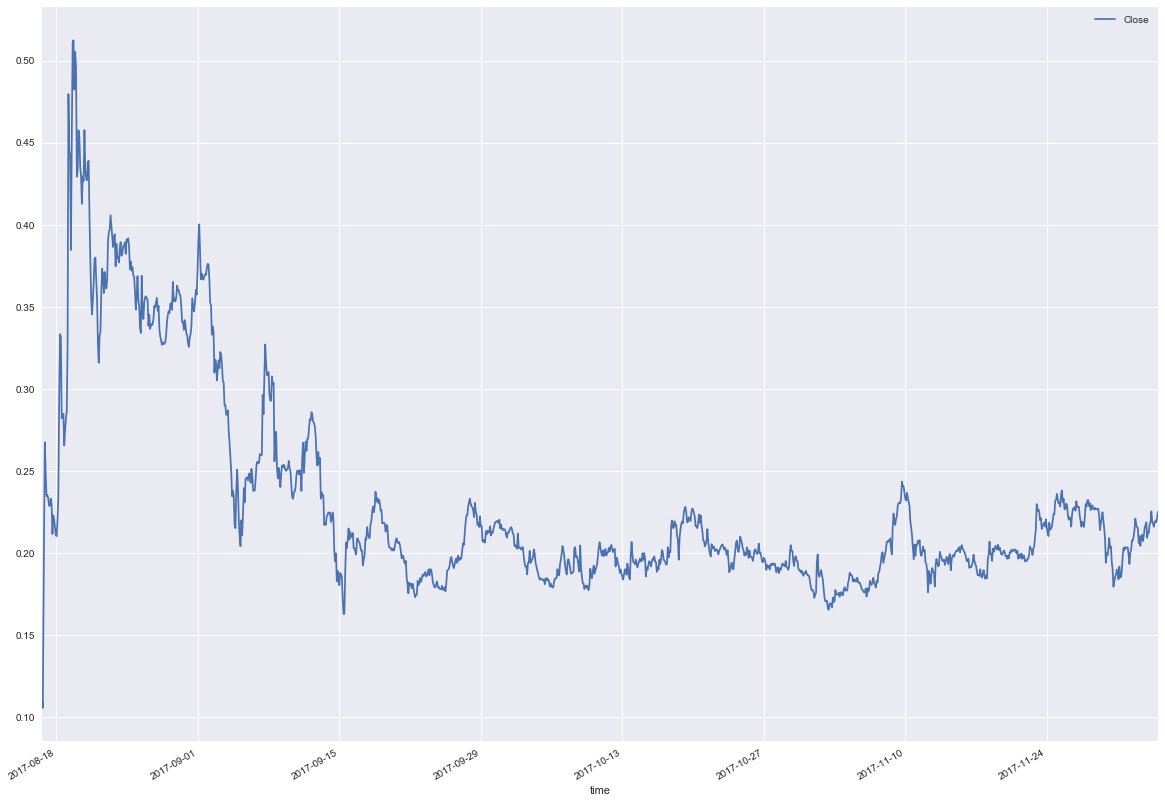

In [37]:
share.plot(figsize = figsize)

In [38]:
from bulbea.learn.evaluation import split
import numpy as np

In [39]:
_, Xtest, _, ytest = split(share, 'Close', normalize = True, train = 0.0)
_,ori_Xtest,_,ori_ytest = split(share, 'Close', normalize = False, train = 0.0)
Xtest  = np.reshape(Xtest, (Xtest.shape[0], Xtest.shape[1], 1))

print(Xtest.shape)
print(ytest.shape)

(1312, 12, 1)
(1312,)


In [40]:
# last_n = -500
# print(len(Xtest))
# Xtest = Xtest[last_n:]
# ytest = ytest[last_n:]
# ori_Xtest = ori_Xtest[last_n:]
# ori_ytest = ori_ytest[last_n:]
# print(len(Xtest))

In [41]:
predicted = model.predict(Xtest)
print(predicted.shape)

(1312, 1)


In [42]:
from sklearn.metrics import mean_squared_error
mean_squared_error(ytest, predicted)

0.0031007804901834299

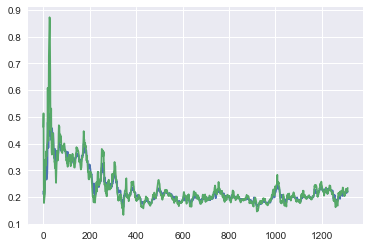

In [43]:
import matplotlib.pyplot as pplt
from bulbea.entity.share import _reverse_cummulative_return

def rever_back(ori_ytest,predicted):
    new_pre = []
    for x in range(0,len(ori_ytest)):
        t = ori_ytest[x]
        predict = predicted[x]
        new_pre.append(_reverse_cummulative_return(t,predict))
    return new_pre

new_pre = rever_back(ori_ytest,predicted)

pplt.plot(ori_ytest)
pplt.plot(new_pre)
pplt.show()

In [44]:
from datetime import timedelta
import pandas as pd


def predict_next_from_current_share(var_share):
    _, Xtest, _, ytest = split(var_share, 'Close', normalize = True, train = 0.0)
    _,ori_Xtest,_,ori_ytest = split(var_share, 'Close', normalize = False, train = 0.0)
    Xtest  = np.reshape(Xtest, (Xtest.shape[0], Xtest.shape[1], 1))

    # Format the Xtest
    last_Xtest = Xtest[-1:]
    last_Xtest  = np.reshape(last_Xtest, (last_Xtest.shape[0], last_Xtest.shape[1], 1))
    
    # Format the ori_ytest
    last_ori_ytest = ori_ytest[-1]
    
    # Get the prediction
    predict = model.predict(last_Xtest)
    
    # convert it back
    new_pre = rever_back([last_ori_ytest],[predict])[0][0][0]
    
    # Append the new data
    new_time = var_share.data.iloc[-1].name + timedelta(hours=1)
    s = pd.Series({"Close":new_pre}, name=new_time)
    new_data = var_share.data.append(s)
    return bb.Share("123",'123',data=new_data)

def predict_next_n_hours(n,share):
    loop_share = share
    for i in range(n):
        print(i)
        return_share = predict_next_from_current_share(loop_share)
        loop_share = return_share
    print(return_share.data)

In [45]:
predict_next_n_hours(10,share)

0


/Users/geleichen/Desktop/NewBillions/bloomberg_crypto/lstm_research/gelei_bulbea/bulbea/entity/share.py:174: UserWarning: Environment variable BULBEA_QUANDL_API_KEY for Quandl hasn't been set. A maximum of 50000 calls per day can be made. Visit https://www.quandl.com to get your API key.
  warnings.warn(message)


1
2
3
4
5
6
7
8
9
                      market_cap  price_btc  price_usd  volume_usd  \
2017-08-16 14:09:21   67035000.0   0.000027   0.111725   3899810.0   
2017-08-16 16:09:22   63363000.0   0.000024   0.105605   4590210.0   
2017-08-16 19:04:24  124583400.0   0.000048   0.207639   5078720.0   
2017-08-16 21:04:31  160462200.0   0.000061   0.267437   5499740.0   
2017-08-16 23:04:27  148759800.0   0.000057   0.247933   5255260.0   
2017-08-17 01:04:28  140770200.0   0.000054   0.234617   5436890.0   
2017-08-17 03:04:23  141229200.0   0.000054   0.235382   5376240.0   
2017-08-17 05:04:42  139929600.0   0.000054   0.233216   5316020.0   
2017-08-17 07:04:58  137233200.0   0.000053   0.228722   5332310.0   
2017-08-17 09:05:03  137248800.0   0.000052   0.228748   5101870.0   
2017-08-17 11:05:03  139880400.0   0.000052   0.233134   4965800.0   
2017-08-17 13:05:03  137800800.0   0.000052   0.229668   4938810.0   
2017-08-17 15:05:05  126891600.0   0.000048   0.211486   4959010.0   
20

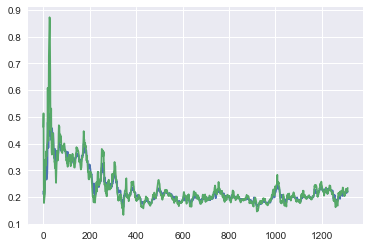

In [46]:
import matplotlib.pyplot as pplt
from bulbea.entity.share import _reverse_cummulative_return

def rever_back(ori_ytest,predicted):
    new_pre = []
    for x in range(0,len(ori_ytest)):
        t = ori_ytest[x]
        predict = predicted[x]
        new_pre.append(_reverse_cummulative_return(t,predict))
    return new_pre

new_pre = rever_back(ori_ytest,predicted)

pplt.plot(ori_ytest)
pplt.plot(new_pre)
pplt.show()